In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analysts focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp<br>
This notebook will demonstrate how to perform a basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock price data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.<br>
I used the Pandas library DataReader to get the historical price stock data from Yahoo Finance API.  The library provides price and volume information regarding stocks. I will use mainly the Adjusted Closing Price ('Adj Close') from the datasets.<br>
In addition, I will use the Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use the calculations from the technical indicators for forecasting.  In addition, I will use  metrics to measure the performance of the models at predicting stock prices.  
The data will consist of the following pharmaceutical companies that are developing  COVID-19 vaccines: 
* Pfizer (PFE),
* Johnson & Johnson (JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE (BNTX)
* MERCK & Co. (MRK)

What are technical Indicators?  Technical indicators are quick methods or mathematical calculations based on the price, volume, or open interest of a security or contract used by traders who follow technical analysis. https://www.investopedia.com/terms/t/technicalindicator.asp Technical indicators are signals produced from the patterns observed in the movements of stock prices (high, low, open, close) and volumes.  These signals are in turn used to predict the future price movements. Techincal Indicators as used in this notebook will provide a historical price analysis  regarding volatility and trends of the stock.  Technical indicators are a fundamental part of technical analysis and are typically plotted as a chart pattern to try to predict the market trend.<br>
Some basic examples of technical indicators which I will cover are:
1. Simple Moving Averages (SMA)
2. Exponential Moving Averages (EMA)
3. Moving Average Convergence Divergence (MACD) Crossover Strategy
4. Relative Strength Index (RSI)

My technical analysis of the stock prices will focus on answering the following questions  which concern price trends, volatility and forecasting:
### Question 1: 
Can technical indicators provide an investor or trader with information to make a decision of whether to buy and sell stocks?<br>
**Answer**: Yes. 
Investment decisions are very complicted and require knowledge and consideration of many variables which are beyond the scope of this notebook.  Technical indicators are tools used by investors and traders to gain insights regarding the stock's history, volatility, trends and the direction the price may be headed.    I will use Moving Averages, price volatility, RSI and MACD crossover strategies to answer this question.  A question to always consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns?<br>
<br>
**Model 1** A Simple Moving Average Plot with a rolling average of 10 and 50 days.<br> 
**Model 2**  An Exponential Moving Average Plot.<br>
**Model 3**  Exponential Moving Average Crossover Stratergy<br>
**Model 4**  Relative Strength Index Plot

### Question 2:
How well do SARIMA algorithms perform when used to forecast future stocks prices?  I will contrast the performance of SARIMA models with data from 'Adj Close' column and data from the above technical indicators.  I will use the RMSE metric to compare the models' performances?<br>
**Model 1** Graph of historical prices for Pfizer stock.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms perform better at predicting stocks prices, LTSM or ARIMA?  I will compare results of both algorithms.<br> 
**Answer:** <br>
**Model 1** is a SARIMA model.<br>


## Historical Stock Data

### Multiple Stocks Data (multi_stocks)

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            label_font = {'weight':'bold','size':18}
            plt.title("Historical Adjusted Price Data",fontdict=label_font)
            plt.xlabel('Dates')
            plt.ylabel('Stocks Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-04-29,38.599998,164.199997,237.529999,175.669998,51.369999,179.649994
2021-04-30,38.650002,162.729996,236.929993,178.820007,53.070000,188.279999
2021-05-03,39.830002,165.210007,195.119995,186.020004,53.700001,208.899994


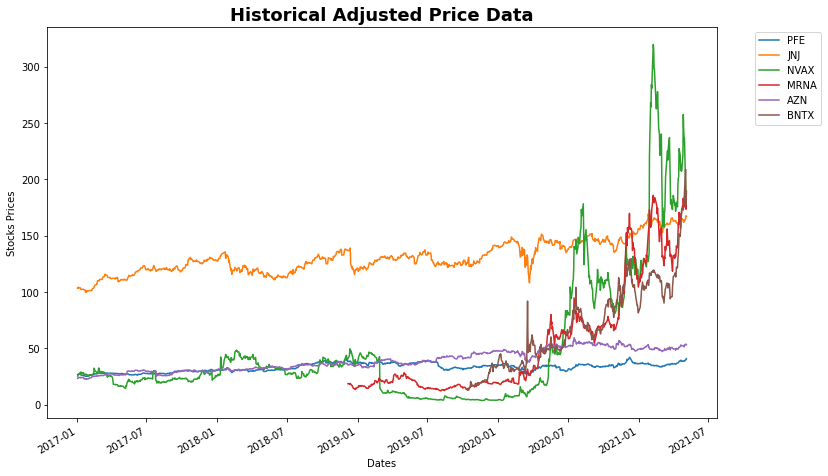

In [3]:
multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
multi_stock_data

In [4]:
multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')

#### Multiple Stock Plot

In [6]:
def multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)            

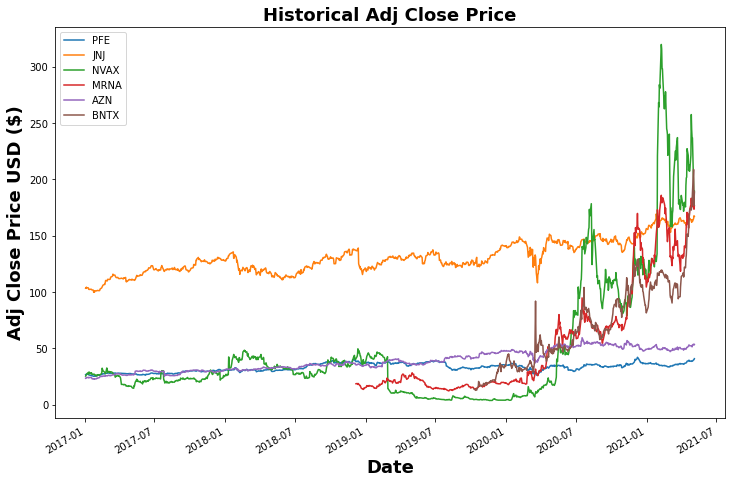

In [7]:
multi_plot(multi_stocks, stock_value='Adj Close')

In [8]:
multi_stocks.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1092.000000,1092.000000,1092.000000,606.000000,1092.000000,395.000000
mean,33.019265,130.759302,47.937262,54.990949,38.975306,70.471569
std,3.719623,14.489286,57.030487,49.124696,9.256544,37.750235
min,25.159119,99.793396,3.690000,12.260000,22.596422,12.750000
25%,30.158155,120.381405,14.022500,18.085000,30.891630,38.540001
50%,33.408768,128.537262,27.500000,25.995000,36.661926,66.040001
75%,36.232543,141.143814,44.000000,72.280003,47.784159,100.084999
max,42.101986,169.423508,319.929993,186.020004,59.466022,208.899994


### Single Stock Data (pfe_stock_data)

In [9]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
        #data = 'Incorrect Symbol'


This is data for Pfizer.

Dataframe has 1092 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928
...,...,...,...,...,...,...
2021-04-29,39.000000,38.310001,38.990002,38.599998,23569400.0,38.599998
2021-04-30,38.900002,38.490002,38.500000,38.650002,28403900.0,38.650002
2021-05-03,39.840000,38.959999,39.040001,39.830002,46638600.0,39.830002


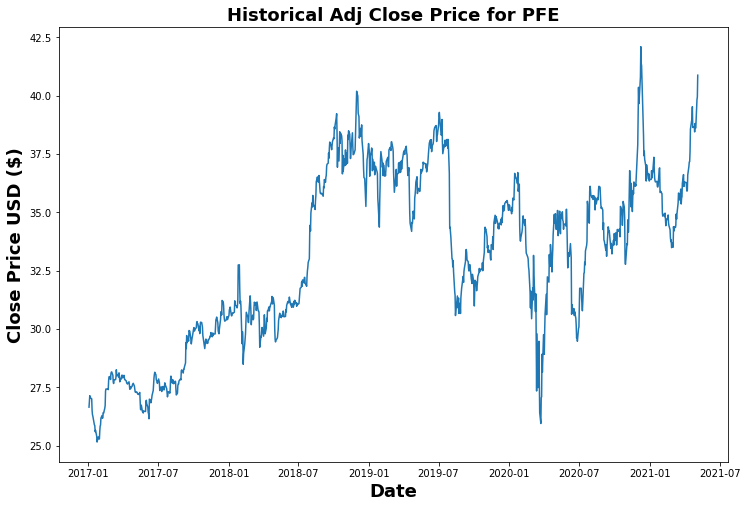

In [10]:
start='01-01-2017'
end='today'
pfe_stock = single_stock_data('PFE', start= start,end='today',plot=True,stock_value='Adj Close')
pfe_stock

In [11]:
pfe_stock.to_csv('pfe_stock')
pfe_stock_df = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data = pfe_stock_df[['Close','Volume','Adj Close']]

In [12]:
pfe_stock_data.describe()

,Close,Volume,Adj Close
count,1092.000000,1.092000e+03,1092.000000
mean,35.635616,2.612820e+07,33.019265
std,3.272234,1.359369e+07,3.719623
min,27.030361,5.187683e+06,25.159119
25%,33.505364,1.828896e+07,30.158155
50%,34.917305,2.304112e+07,33.408768
75%,38.020308,2.956191e+07,36.232543
max,43.861481,2.301539e+08,42.101986


#### Single Stock Plot

In [13]:
def single_plot(df,stock_value=None, stock_symbol=None):
    df[stock_value].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'{stock_symbol} {stock_value} History',fontdict=label_font)                

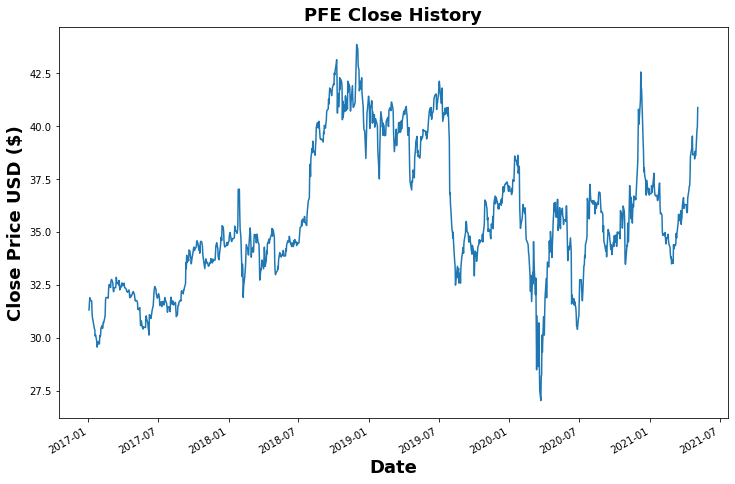

In [14]:
single_plot(pfe_stock_data, stock_value='Close', stock_symbol='PFE')

## Question 2: <br>Does the SARIMA algorithm perform better in predicting future stocks price with the Adj Close column or Technical Indicators ? 
This section focuses on using SARIMA models to predict future stock prices.  Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.  Although the method can handle data with a trend, it does not support time series with a seasonal component.  Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

I will be working with univariate time series datasets.  I have created various functions which make it easy to work with different datasets and get corresponding predictions and plots.  I am starting with Pfizer then I will run the model with BVAX for a comparison.<br>
I created the function delta_data in order to add the calculations from the Techincal Indicators section to the stock dataset I obtained from Datareader.  I will be working with the columns Adj Close, MA_50 and Actual_Changes.

Adj Close:
<br>
The data covers the time period 3/15/17 to 4/1/21.  I applied the describe function to the 'Adj Close' column which provides a quick statistical overview of the data.  The average price of the stock was \\$33.20.  Regarding price range, the lowest price it reached was \\$25.95 and the highest was \\$42.10.  The std was 3.497 so the data points generally didn't deviate that far from each other.<br>
<br>

To make the predictions I will be using One-Step Ahead forecasting and Dynamic Forecasting. One Step Ahead static and dynamic forecasts are similar. The difference is with their estimation procedures. Dynamic forecasts use the value of the previous forecasted value of the dependent variable to compute the next one. Static forecast use the actual value for each subsequent forecast.

In [15]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

## Sarima Model

In [16]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

import statsmodels.api as sm

In [17]:
sarima_data = pfe_stock_data.copy()

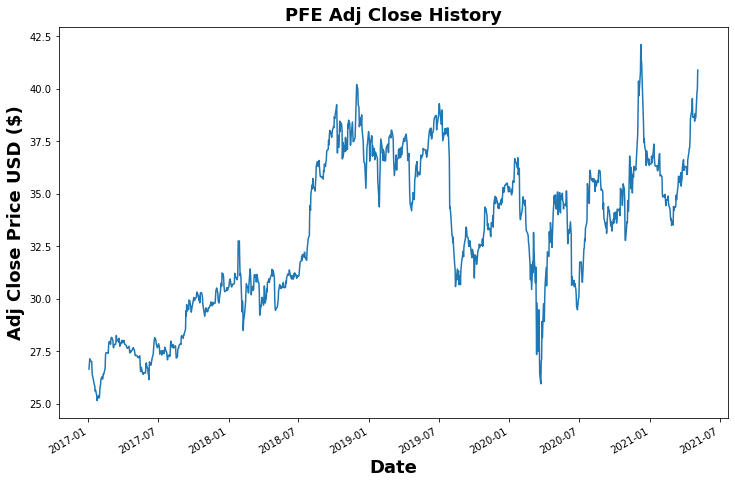

In [18]:
single_plot(pfe_stock_data, stock_value='Adj Close', stock_symbol='PFE')

#### Delta_data

In [19]:
def delta_data(data,col=None):
    data['Actual_Changes'] = data[col] - data[col].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    
    data = data.dropna()
    return data

In [20]:
sarima_df = delta_data(sarima_data,col='Adj Close')#delta_time_series(multi_stocks, col='Adj Close')
sarima_df

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2017-03-15,32.855785,24279839.0,28.254789,0.334522,0.011981,26.801835
2017-03-16,32.666035,21816219.0,28.091606,-0.163183,-0.005775,26.830601
2017-03-17,32.561668,45736117.0,28.001856,-0.089750,-0.003195,26.852887
2017-03-20,32.618595,18435514.0,28.050808,0.048952,0.001748,26.870983
2017-03-21,32.495255,33083479.0,27.944742,-0.106066,-0.003781,26.889058
...,...,...,...,...,...,...
2021-04-29,38.599998,23569400.0,38.599998,-0.210003,-0.005411,36.037400
2021-04-30,38.650002,28403900.0,38.650002,0.050003,0.001295,36.119200
2021-05-03,39.830002,46638600.0,39.830002,1.180000,0.030530,36.227000


In [21]:
sarima_df

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2017-03-15,32.855785,24279839.0,28.254789,0.334522,0.011981,26.801835
2017-03-16,32.666035,21816219.0,28.091606,-0.163183,-0.005775,26.830601
2017-03-17,32.561668,45736117.0,28.001856,-0.089750,-0.003195,26.852887
2017-03-20,32.618595,18435514.0,28.050808,0.048952,0.001748,26.870983
2017-03-21,32.495255,33083479.0,27.944742,-0.106066,-0.003781,26.889058
...,...,...,...,...,...,...
2021-04-29,38.599998,23569400.0,38.599998,-0.210003,-0.005411,36.037400
2021-04-30,38.650002,28403900.0,38.650002,0.050003,0.001295,36.119200
2021-05-03,39.830002,46638600.0,39.830002,1.180000,0.030530,36.227000


In [22]:
sarima_df['Adj Close'].describe()

count    1043.000000
mean       33.312752
std         3.538837
min        25.952459
25%        30.531761
50%        33.750000
75%        36.309774
max        42.101986
Name: Adj Close, dtype: float64

In [23]:
sarima_df.describe()

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
count,1043.000000,1.043000e+03,1043.000000,1043.000000,1043.000000,1043.000000
mean,35.841285,2.607834e+07,33.312752,0.012425,0.000472,33.067753
std,3.196847,1.382735e+07,3.538837,0.484165,0.014581,3.337164
min,27.030361,5.187683e+06,25.952459,-2.511635,-0.077347,26.801835
25%,33.733397,1.809586e+07,30.531761,-0.181915,-0.005495,30.547630
50%,35.037952,2.267987e+07,33.750000,0.009998,0.000303,33.346352
75%,38.529411,2.950821e+07,36.309774,0.225491,0.006799,36.341275
max,43.861481,2.301539e+08,42.101986,2.627960,0.089607,38.114337


##### Train/Test Split

In [23]:
train = sarima_df[:int(0.8*(len(sarima_df)))]
test = sarima_df[int(0.8*(len(sarima_df))):]

In [24]:
len(sarima_df),len(train), len(test)

(1040, 832, 208)

In [25]:
test

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2020-07-06,32.741936,27150935.0,31.749561,0.000000,0.000000,33.007060
2020-07-07,32.286530,25148018.0,31.307959,-0.441603,-0.013909,32.952206
2020-07-08,32.020874,24256545.0,31.050354,-0.257605,-0.008228,32.874893
2020-07-09,31.745731,20363702.0,30.783550,-0.266804,-0.008593,32.799895
2020-07-10,32.096775,24459019.0,31.123955,0.340405,0.011058,32.727879
...,...,...,...,...,...,...
2021-04-26,38.680000,19773400.0,38.680000,0.020000,0.000517,35.806200
2021-04-27,38.450001,19061500.0,38.450001,-0.230000,-0.005946,35.880800
2021-04-28,38.810001,21963300.0,38.810001,0.360001,0.009363,35.963200


In [26]:
test['Adj Close'].describe()

count    208.000000
mean      35.542515
std        1.904978
min       30.783550
25%       34.255755
50%       35.536814
75%       36.344620
max       42.101986
Name: Adj Close, dtype: float64

##### Auto ARIMA Model Function

In [27]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [28]:
adj_close = 'Adj Close'
ma_50 = 'MA_50'
actual_changes = 'Actual_Changes'

#### Pfizer / Adj Close

##### Code to get PDQs and AIC

In [29]:
#for loop iterates to get the PDQs, Seasonal PDQs and AICS for each column
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

,hist,pdq,seasonal_pdq,aic
0,Close,"(3, 0, 0)","(1, 1, 1, 12)",1596.605456
1,Volume,"(2, 0, 1)","(1, 1, 2, 12)",36504.339145
2,Adj Close,"(3, 0, 0)","(1, 1, 1, 12)",1471.762792
3,Actual_Changes,"(1, 0, 3)","(1, 1, 1, 12)",1468.380407
4,Percent_Chg,"(0, 0, 1)","(0, 1, 1, 12)",-5724.917406
5,MA_50,"(3, 0, 3)","(2, 1, 2, 12)",-5780.725663


In [30]:
#function that fit SARIMA model
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

#### One Step Ahead Forecasting

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                 1040
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -726.369
Date:                              Fri, 30 Apr 2021   AIC                           1464.737
Time:                                      16:09:32   BIC                           1494.261
Sample:                                           0   HQIC                          1475.952
                                             - 1040                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9280      0.019     48.605      0.000       0.891       0.965
ar.L2          0.1173      0.025      4.651      0.000       0.068       0.167
ar.L3         -0.0555      0.020     -2.763      0.006      -0.095      -0.016
ar.S.L12       0.0379      0.027      1.397      0.162      -0.015       0.091
ma.S.L12      -1.0000     56.544     -0.018      0.986    -111.824     109.824
sigma2         0.2334     13.197      0.018      0.986     -25.632      26.098
===================================================================================
Ljung-Box (Q):                       84.95   Jarque-Bera (JB):              1171.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


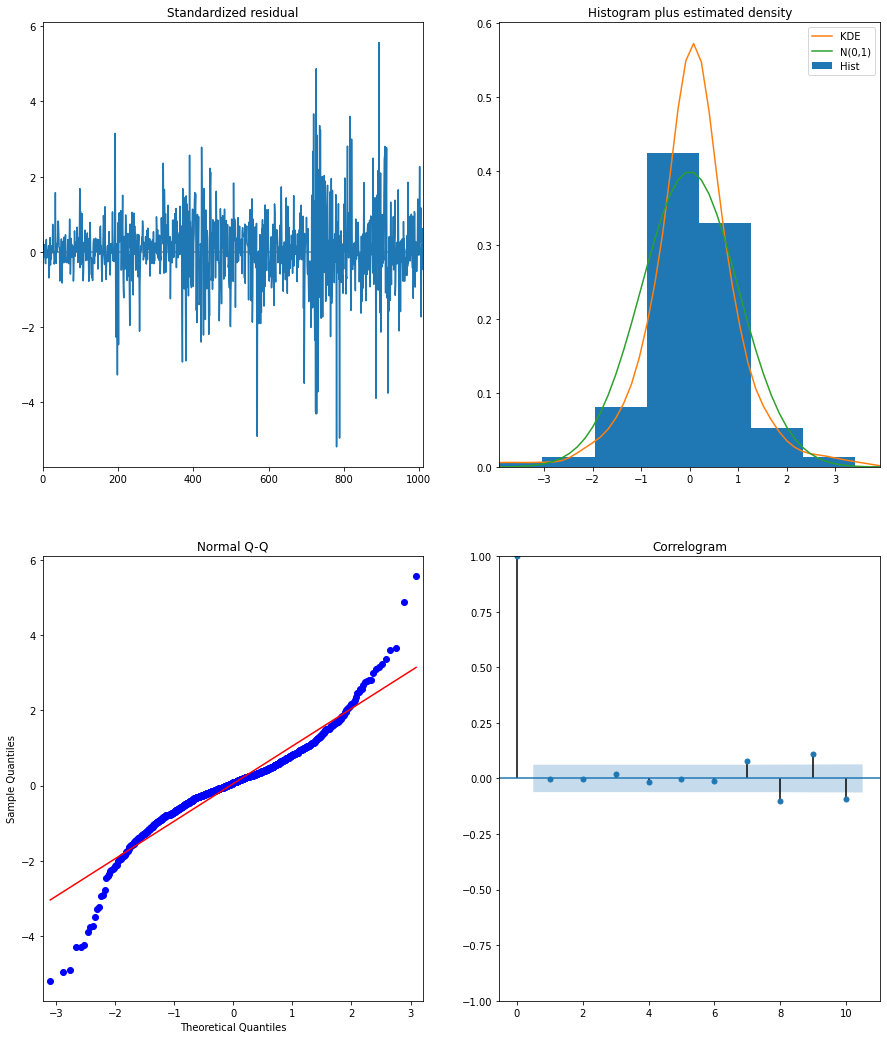

In [31]:
#code for one-step ahead forecasting
hist_type = adj_close #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

##### One-Step Ahead Plot

This plot pertains to the One Step Ahead Forecasting.  The green line in the plot represents the prediction. The green line has a shaded green area around it called the confidence intervals.  What are confidence intervals?  Confidence intervals are a range in values.  The default alpha of .05 returns a 95% confidence interval.  A 95% confidence interval represents that if we take an infinite number of samples from the population, calculate the interval each time, then in 95% of those intervals, the interval will contain the true population mean.   This represents the model’s uncertainty in the forecast.  <br> 
In this case, the confidence interval width is set at 95%, meaning we expect that this range will contain the actual value 95% of the time. Any time a prediction is made we must include a confidence interval.<br>
The orange line represents the test set. We can tell from the plot that the model is performing pretty well because the green line follows the orange line closely.  When the RMSE metric is applied to the model to evaluate its performence we see that the model's performance was 0.54.  The average price of the stock was \\$33.22.  This means that in making the predictions the model was off 0.54.  The model did a pretty good job at forecasting the prediction.<br>

In [32]:
def one_step(train, test, one_adj_c, pred, pred_conf):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c ]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

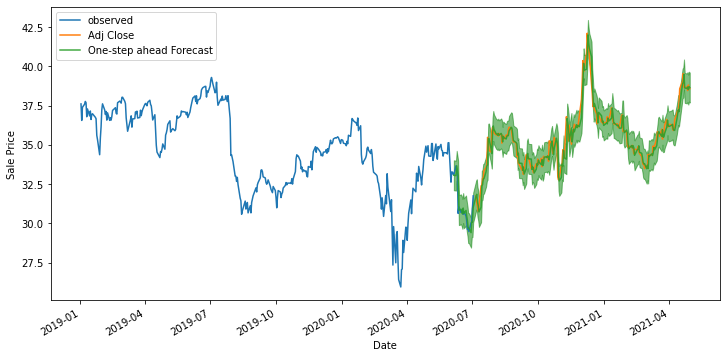

In [33]:
one_step_forecast = one_step(train=train, test=test, one_adj_c= adj_close, pred=pred,pred_conf=pred_conf)

##### Metrics Function for One-Step Ahead

In [34]:
def metric_func_one(pred, test, sarima_col):
    # Get the real and predicted values
    forecast = pred.predicted_mean
    actual =test[sarima_col] #actual =test['Adj Close']['1996':], was RMSE 0.54

    #root mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
    
    return mse, rmse

In [35]:
one_mse_adj, one_rmse_adj = metric_func_one(pred, test, sarima_col= adj_close)

The Mean Squared Error of our forecasts is 0.29
The Root Mean Squared Error of our forecasts is 0.53


In [36]:
one_rmse_adj

0.5348770367723708

#### Dynamic Forecasting 
The average price for 'Adj Close' is \\$33.215.  The average price for the test set is \\$35.01.  The green line is the prediction.  It looks like the model predicted the price to be around \\$34.00.  It looks like the model did a pretty good job in making predictions because the predictions are close to the average price.  The below metric function shows that the model's performance was \\$2.71, so for the predictions the model was off \\$2.71.   

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                 1040
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -726.369
Date:                              Fri, 30 Apr 2021   AIC                           1464.737
Time:                                      16:09:39   BIC                           1494.261
Sample:                                           0   HQIC                          1475.952
                                             - 1040                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9280      0.019     48.605      0.000       0.891       0.965
ar.L2          0.1173      0.025      4.651      0.000       0.068       0.167
ar.L3         -0.0555      0.020     -2.763      0.006      -0.095      -0.016
ar.S.L12       0.0379      0.027      1.397      0.162      -0.015       0.091
ma.S.L12      -1.0000     56.544     -0.018      0.986    -111.824     109.824
sigma2         0.2334     13.197      0.018      0.986     -25.632      26.098
===================================================================================
Ljung-Box (Q):                       84.95   Jarque-Bera (JB):              1171.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


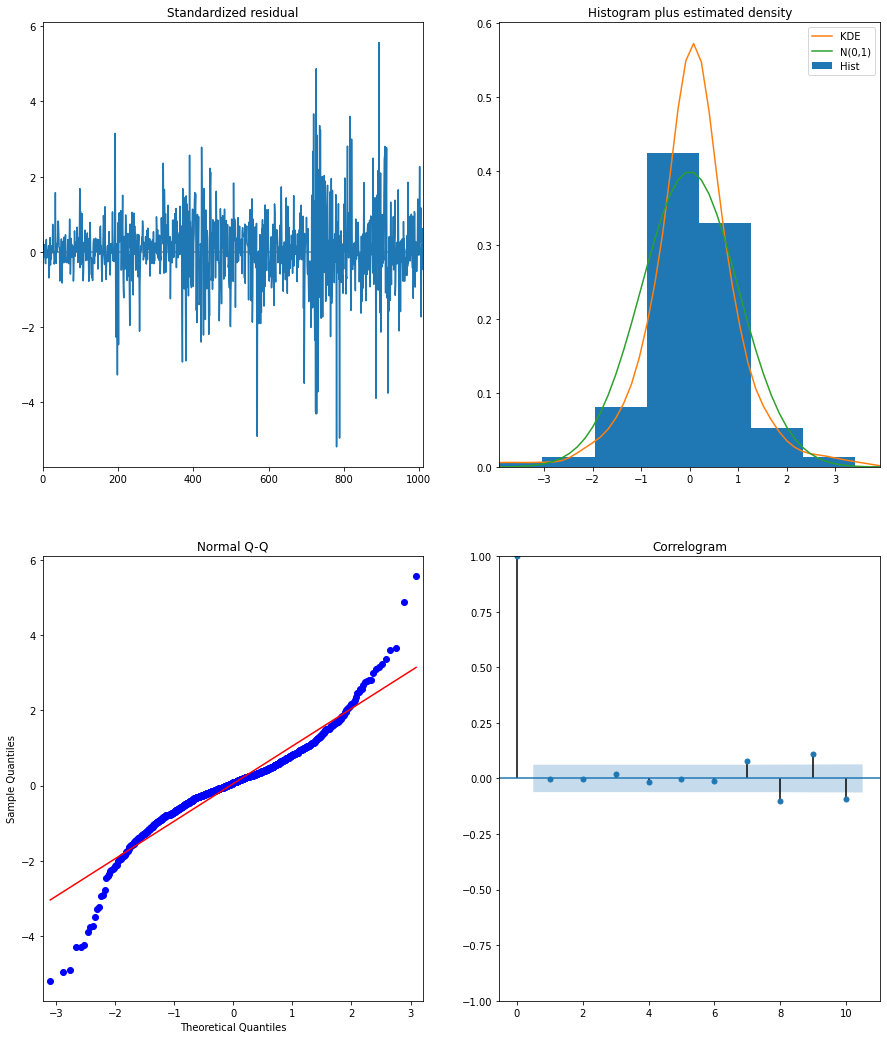

In [37]:
#dynamic forecasting
history_type = adj_close #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

##### Dynamic Forecasting Plot


In [38]:
def prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

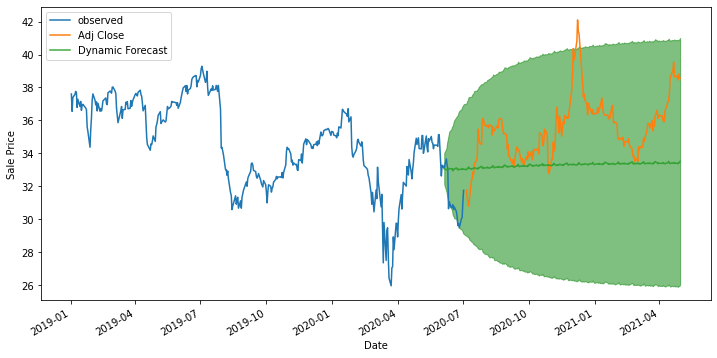

In [39]:
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test, one_adj_c= adj_close)#'Adj Close'

##### Metrics Function for Dynamic Forecasting

In [40]:
def metric_func_dynamic(pred_dynamic, test, sarima_col):
    # Get the real and predicted values
    forecast = pred_dynamic.predicted_mean
    actual = test[sarima_col]#['1996':] #history_type

    # Compute the mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of the forecast is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of the forecast is {}'.format(round(rmse, 2)))
    
    return mse, rmse
    

In [41]:
dyn_mse_adj,dyn_rmse_adj,  = metric_func_dynamic(pred_dynamic, test, sarima_col =adj_close)

The Mean Squared Error of the forecast is 8.48
The Root Mean Squared Error of the forecast is 2.91


In [42]:
dyn_rmse_adj

2.9117752954115805

#### Pfizer / One-Step / MA_50
The model performed well in making predictions. The green line follows closely the orange line.  I applied the RMSE to the model and the result was 0.02.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                 1040
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                2704.633
Date:                                 Fri, 30 Apr 2021   AIC                          -5387.265
Time:                                         16:09:55   BIC                          -5333.280
Sample:                                              0   HQIC                         -5366.747
                                                - 1040                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.5302      0.093     27.254      0.000       2.348       2.712
ar.L2         -2.1067      0.181    -11.633      0.000      -2.462      -1.752
ar.L3          0.5747      0.089      6.477      0.000       0.401       0.749
ma.L1         -0.5134      0.091     -5.654      0.000      -0.691      -0.335
ma.L2          0.2559      0.026      9.743      0.000       0.204       0.307
ma.L3          0.0687      0.040      1.721      0.085      -0.010       0.147
ar.S.L12      -0.3815      0.026    -14.795      0.000      -0.432      -0.331
ar.S.L24      -0.0126      0.026     -0.491      0.624      -0.063       0.038
ma.S.L12       9.3141      0.000   3.02e+04      0.000       9.313       9.315
ma.S.L24      -1.6283      0.004   -464.173      0.000      -1.635      -1.621
sigma2        2.8e-06    1.1e-07     25.467      0.000    2.58e-06    3.02e-06
===================================================================================
Ljung-Box (Q):                      365.54   Jarque-Bera (JB):                69.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+21. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


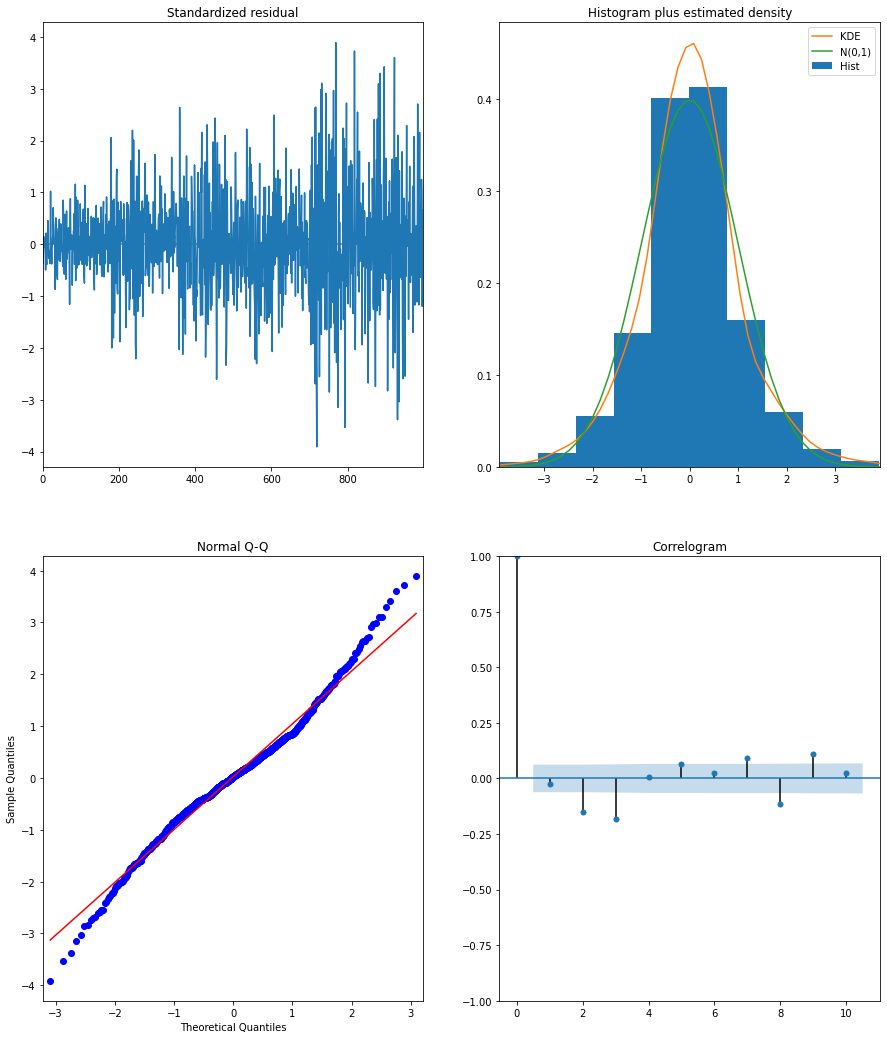

In [43]:
hist_type = ma_50 
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

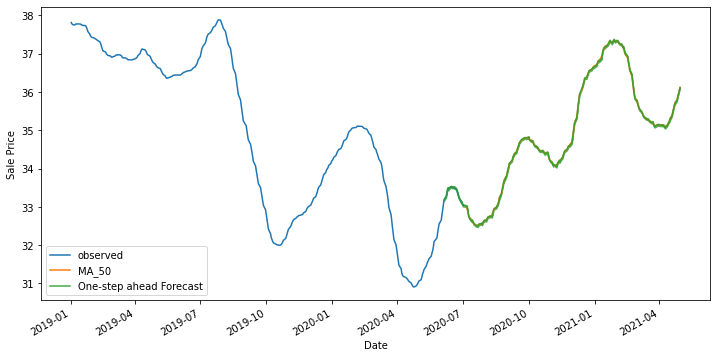

In [44]:
one_step_forecast_1 = one_step(train=train, test=test, one_adj_c= ma_50, pred=pred,pred_conf=pred_conf)

In [45]:
metric_func_1 = metric_func_one(pred, test, ma_50)

The Mean Squared Error of our forecasts is 0.0
The Root Mean Squared Error of our forecasts is 0.02


In [46]:
test['MA_50']

Date
2020-07-06    33.007060
2020-07-07    32.952206
2020-07-08    32.874893
2020-07-09    32.799895
2020-07-10    32.727879
                ...    
2021-04-26    35.806200
2021-04-27    35.880800
2021-04-28    35.963200
2021-04-29    36.037400
2021-04-30    36.117598
Name: MA_50, Length: 208, dtype: float64

#### Pfizer/ Dynamic / MA_50
The model doesn't appear to have performed as well with this column. The model's green line fluctuates betwee 36 and 33 but after 12/20 is predicting 34.  However, when evaluating the model's performane the predictions were off 1.72 so it still performed pretty well. 

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                 1040
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                2704.633
Date:                                 Fri, 30 Apr 2021   AIC                          -5387.265
Time:                                         16:10:16   BIC                          -5333.280
Sample:                                              0   HQIC                         -5366.747
                                                - 1040                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.5302      0.093     27.254      0.000       2.348       2.712
ar.L2         -2.1067      0.181    -11.633      0.000      -2.462      -1.752
ar.L3          0.5747      0.089      6.477      0.000       0.401       0.749
ma.L1         -0.5134      0.091     -5.654      0.000      -0.691      -0.335
ma.L2          0.2559      0.026      9.743      0.000       0.204       0.307
ma.L3          0.0687      0.040      1.721      0.085      -0.010       0.147
ar.S.L12      -0.3815      0.026    -14.795      0.000      -0.432      -0.331
ar.S.L24      -0.0126      0.026     -0.491      0.624      -0.063       0.038
ma.S.L12       9.3141      0.000   3.02e+04      0.000       9.313       9.315
ma.S.L24      -1.6283      0.004   -464.173      0.000      -1.635      -1.621
sigma2        2.8e-06    1.1e-07     25.467      0.000    2.58e-06    3.02e-06
===================================================================================
Ljung-Box (Q):                      365.54   Jarque-Bera (JB):                69.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+21. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


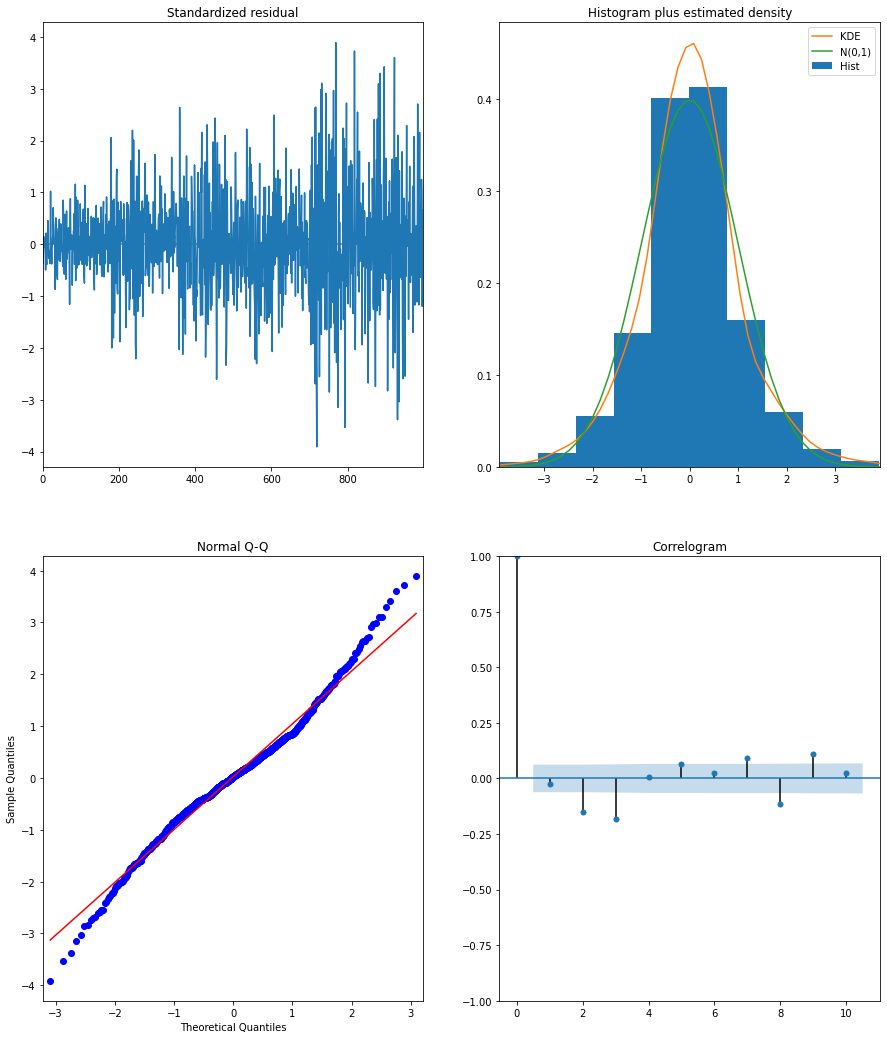

In [47]:
history_type = ma_50 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

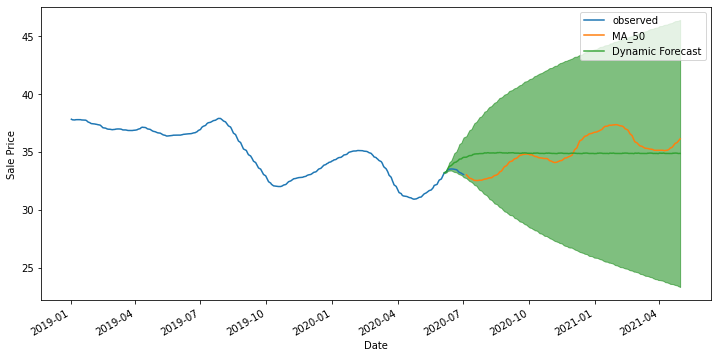

In [48]:
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= 'MA_50')

In [49]:
metric_func_dynamic(pred_dynamic, test, ma_50)

The Mean Squared Error of the forecast is 1.93
The Root Mean Squared Error of the forecast is 1.39


(1.934845274543013, 1.390987158295508)

#### Pfizer / Actual_Changes
The model's predictions are centered around 0. The confidence intervals indicate there's a quite a range of values in the test set.  The model's performance was 0.54.


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                 1040
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -720.363
Date:                              Fri, 30 Apr 2021   AIC                           1454.726
Time:                                      16:10:26   BIC                           1489.163
Sample:                                           0   HQIC                          1467.807
                                             - 1040                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8698      0.049    -17.704      0.000      -0.966      -0.773
ma.L1          0.8152      0.052     15.810      0.000       0.714       0.916
ma.L2         -0.0125      0.028     -0.445      0.656      -0.067       0.042
ma.L3          0.0896      0.023      3.967      0.000       0.045       0.134
ar.S.L12     3.23e-06      0.028      0.000      1.000      -0.055       0.055
ma.S.L12      -1.0000      8.890     -0.112      0.910     -18.423      16.423
sigma2         0.2322      2.063      0.113      0.910      -3.811       4.276
===================================================================================
Ljung-Box (Q):                       73.20   Jarque-Bera (JB):              1073.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


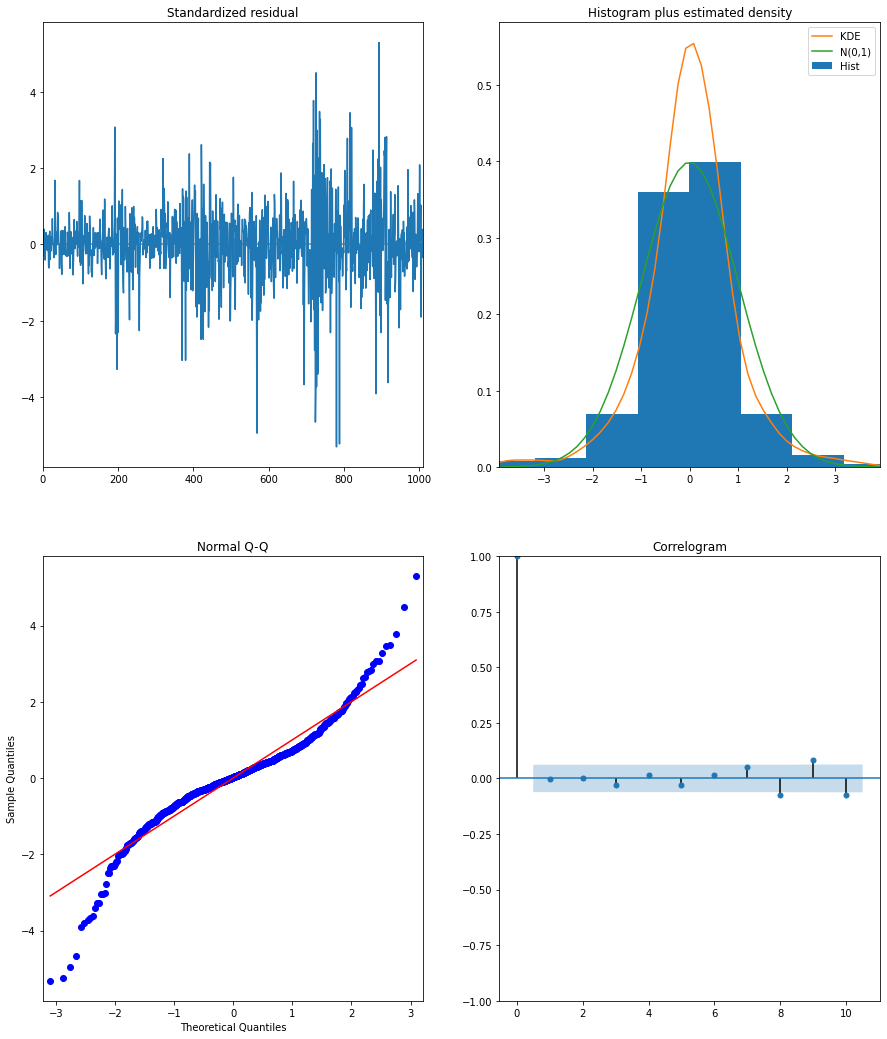

In [50]:
hist_type = actual_changes  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

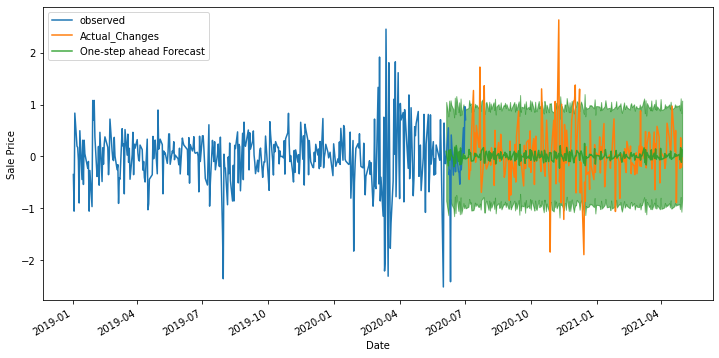

In [51]:
one_step_forecast_2 = one_step(train=train, test=test, one_adj_c= actual_changes, pred=pred,pred_conf=pred_conf)

In [52]:
metric_func_2 = metric_func_one(pred, test, actual_changes)

The Mean Squared Error of our forecasts is 0.28
The Root Mean Squared Error of our forecasts is 0.53


Regarding Dynamic Forecasting, the model's predictions were centered around 0. The confidence intervals have a large rang in possible values. 

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                 1040
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -720.363
Date:                              Fri, 30 Apr 2021   AIC                           1454.726
Time:                                      16:10:37   BIC                           1489.163
Sample:                                           0   HQIC                          1467.807
                                             - 1040                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8698      0.049    -17.704      0.000      -0.966      -0.773
ma.L1          0.8152      0.052     15.810      0.000       0.714       0.916
ma.L2         -0.0125      0.028     -0.445      0.656      -0.067       0.042
ma.L3          0.0896      0.023      3.967      0.000       0.045       0.134
ar.S.L12     3.23e-06      0.028      0.000      1.000      -0.055       0.055
ma.S.L12      -1.0000      8.890     -0.112      0.910     -18.423      16.423
sigma2         0.2322      2.063      0.113      0.910      -3.811       4.276
===================================================================================
Ljung-Box (Q):                       73.20   Jarque-Bera (JB):              1073.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


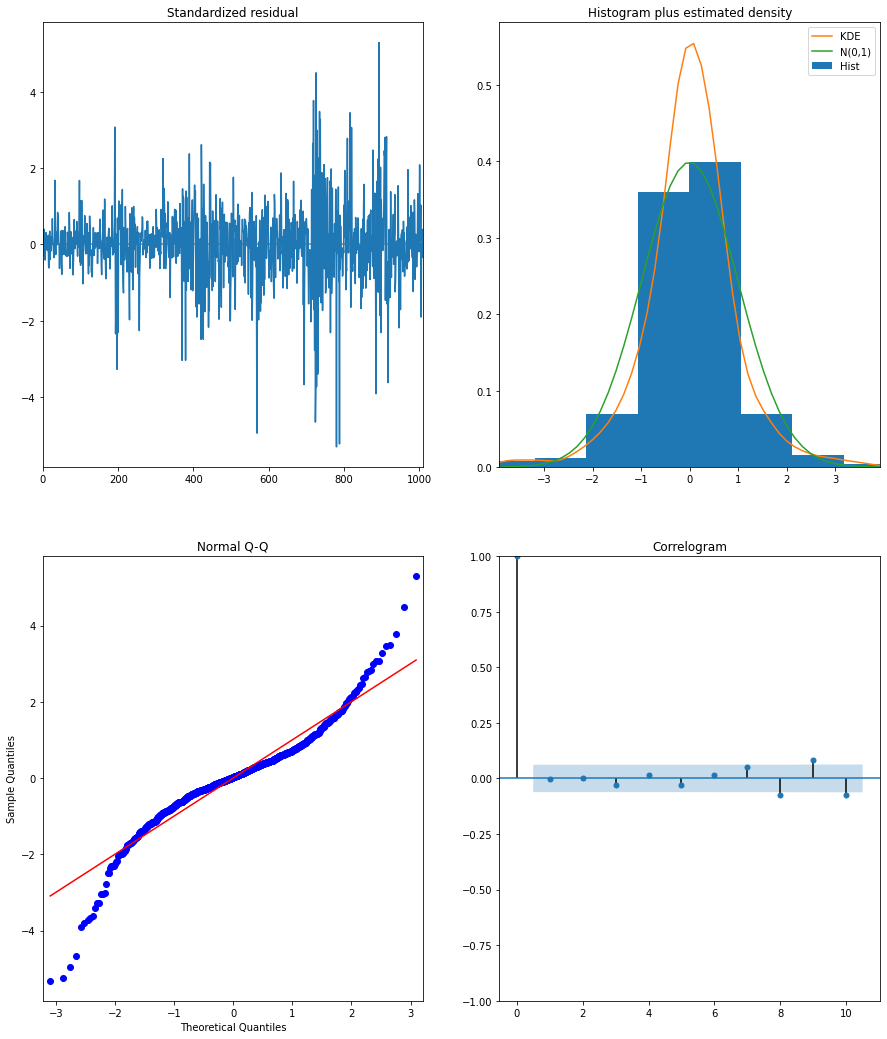

In [53]:
history_type = actual_changes  #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

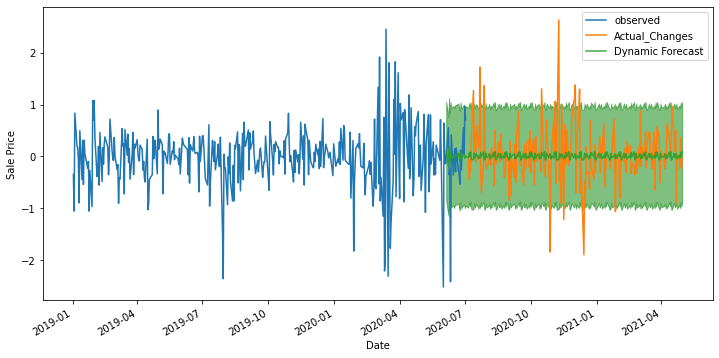

In [54]:
prediction_visual_3 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= actual_changes)


In [55]:
metric_func_dynamic(pred_dynamic, test, actual_changes)

The Mean Squared Error of the forecast is 0.28
The Root Mean Squared Error of the forecast is 0.53


(0.2834823068426089, 0.5324305652783364)

#### BNTX 

Dataframe has 392 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-10-10,16.698999,13.010000,16.500000,14.240000,2805800,14.240000
2019-10-11,15.340000,13.500000,15.340000,13.820000,1364300,13.820000
2019-10-14,13.910000,12.525000,13.830000,12.750000,899100,12.750000
2019-10-15,13.000000,12.530000,12.990000,12.920000,484700,12.920000
2019-10-16,13.880000,12.610000,13.200000,12.940000,524200,12.940000
...,...,...,...,...,...,...
2021-04-26,174.770004,161.539993,167.791000,174.649994,3087500,174.649994
2021-04-27,175.880005,169.264008,173.369995,172.839996,2061900,172.839996
2021-04-28,177.190002,169.300003,171.979996,175.770004,1507200,175.770004


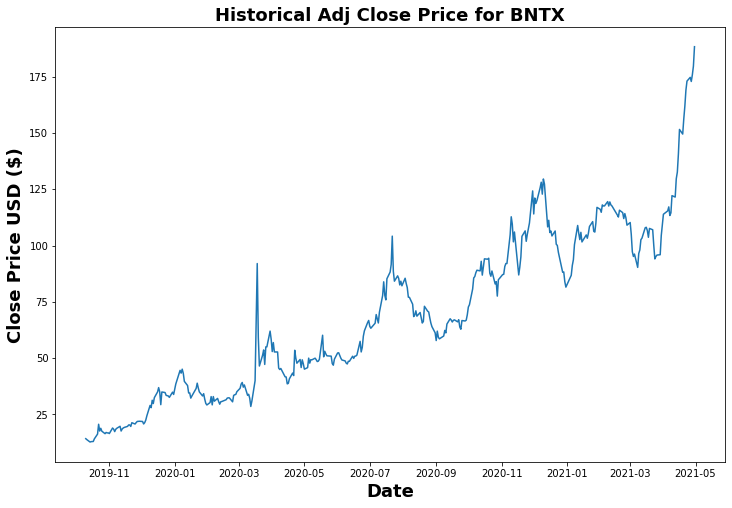

In [56]:
start='01-01-2017'
end='today'
bntx_stock = single_stock_data('BNTX', start= start,end='today',plot=True,stock_value='Adj Close')
bntx_stock

In [57]:
bntx_stock['Adj Close'].describe()

count    392.000000
mean      69.545510
std       36.352005
min       12.750000
25%       38.495000
50%       65.705002
75%       97.442499
max      188.279999
Name: Adj Close, dtype: float64

In [58]:
bntx_df = delta_data(bntx_stock,col='Adj Close')
train = bntx_df[:int(0.8*(len(bntx_df)))]
test = bntx_df[int(0.8*(len(bntx_df))):]

In [59]:
train

,High,Low,Open,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,,,,
2019-12-19,33.869999,27.728001,33.869999,29.340000,250500,29.340000,-5.660000,-0.161714,20.794800
2019-12-20,34.970001,31.809999,31.809999,34.970001,447900,34.970001,5.630001,0.191888,21.209400
2019-12-23,35.900002,33.099998,34.910000,34.730000,103500,34.730000,-0.240002,-0.006863,21.627600
2019-12-24,34.610001,33.009998,34.610001,33.470001,23900,33.470001,-1.259998,-0.036280,22.042000
2019-12-26,34.000000,31.591000,33.290001,33.200001,53900,33.200001,-0.270000,-0.008067,22.447600
...,...,...,...,...,...,...,...,...,...
2021-01-14,106.500000,102.260002,102.790001,105.849998,1910200,105.849998,3.239998,0.031576,103.632200
2021-01-15,104.989998,97.250000,104.250000,101.589996,3151600,101.589996,-4.260002,-0.040246,103.919599
2021-01-19,105.440002,100.199997,101.260002,104.699997,2018200,104.699997,3.110001,0.030613,104.199799


In [60]:
test

,High,Low,Open,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,,,,
2021-01-22,108.480003,104.315002,104.500000,108.440002,1696300,108.440002,3.010002,0.028550,104.765799
2021-01-25,110.980003,105.139999,108.000000,110.610001,2882600,110.610001,2.169998,0.020011,104.722799
2021-01-26,112.832001,105.489998,110.279999,106.290001,3863900,106.290001,-4.320000,-0.039056,104.659599
2021-01-27,110.863998,103.019997,105.150002,105.970001,2139600,105.970001,-0.320000,-0.003011,104.746400
2021-01-28,111.239998,106.599998,107.662003,110.000000,2296600,110.000000,4.029999,0.038030,104.826400
...,...,...,...,...,...,...,...,...,...
2021-04-26,174.770004,161.539993,167.791000,174.649994,3087500,174.649994,1.649994,0.009538,116.445800
2021-04-27,175.880005,169.264008,173.369995,172.839996,2061900,172.839996,-1.809998,-0.010364,117.551400
2021-04-28,177.190002,169.300003,171.979996,175.770004,1507200,175.770004,2.930008,0.016952,118.779200


#### BNTX / Adj Close
##### BNTX / One-Step Ahead
The green line follows the orange line closely.  The model's performance was 3.91. 

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  343
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -970.607
Date:                              Fri, 30 Apr 2021   AIC                           1953.214
Time:                                      16:10:42   BIC                           1975.748
Sample:                                           0   HQIC                          1962.216
                                              - 343                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0545      0.035     30.108      0.000       0.986       1.123
ar.L2         -0.1471      0.074     -1.999      0.046      -0.291      -0.003
ar.L3          0.0977      0.046      2.112      0.035       0.007       0.188
ar.S.L12      -0.0002      0.057     -0.003      0.998      -0.111       0.111
ma.S.L12      -1.0000    386.773     -0.003      0.998    -759.061     757.061
sigma2        24.6438   9531.833      0.003      0.998   -1.87e+04    1.87e+04
===================================================================================
Ljung-Box (Q):                       25.62   Jarque-Bera (JB):               560.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.25
Prob(H) (two-sided):                  0.37   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


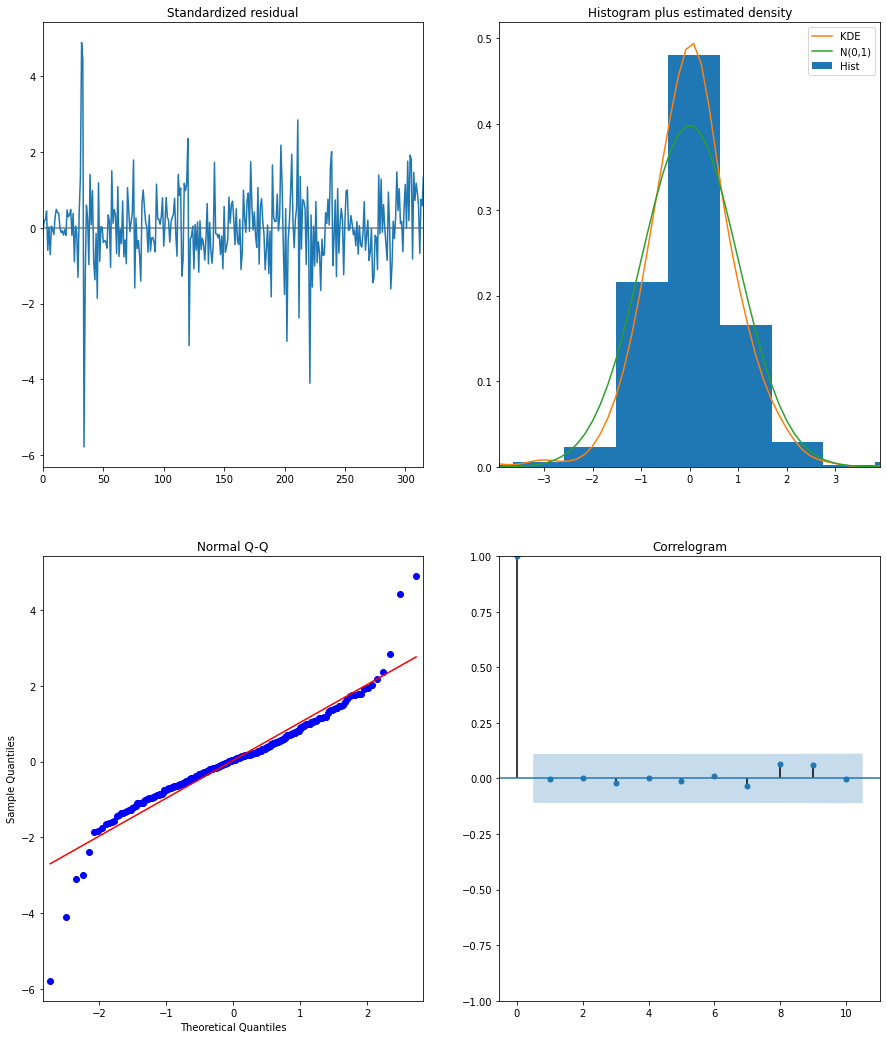

In [61]:
hist_type = adj_close #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=False)
pred_conf = pred.conf_int()

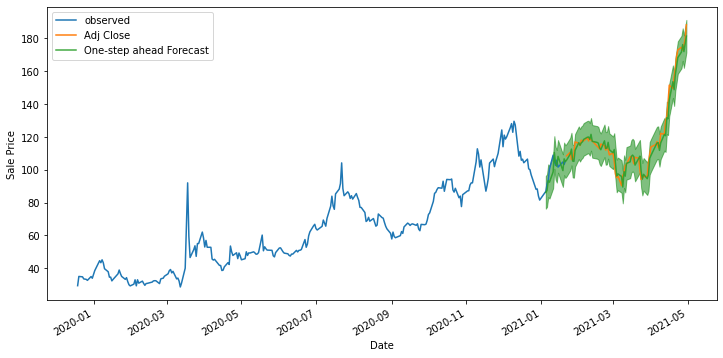

In [62]:
#blue actual
#green line is forecast
#orange-test 
#green shade confidence interval
one_step_forecast_4 = one_step(train=train, test=test, one_adj_c= adj_close, pred=pred,pred_conf=pred_conf)

In [63]:

metric_func_one(pred, test, sarima_col= adj_close)

The Mean Squared Error of our forecasts is 17.33
The Root Mean Squared Error of our forecasts is 4.16


(17.325106076606694, 4.162343820085829)

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  343
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -970.607
Date:                              Fri, 30 Apr 2021   AIC                           1953.214
Time:                                      16:10:45   BIC                           1975.748
Sample:                                           0   HQIC                          1962.216
                                              - 343                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0545      0.035     30.108      0.000       0.986       1.123
ar.L2         -0.1471      0.074     -1.999      0.046      -0.291      -0.003
ar.L3          0.0977      0.046      2.112      0.035       0.007       0.188
ar.S.L12      -0.0002      0.057     -0.003      0.998      -0.111       0.111
ma.S.L12      -1.0000    386.773     -0.003      0.998    -759.061     757.061
sigma2        24.6438   9531.833      0.003      0.998   -1.87e+04    1.87e+04
===================================================================================
Ljung-Box (Q):                       25.62   Jarque-Bera (JB):               560.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.25
Prob(H) (two-sided):                  0.37   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


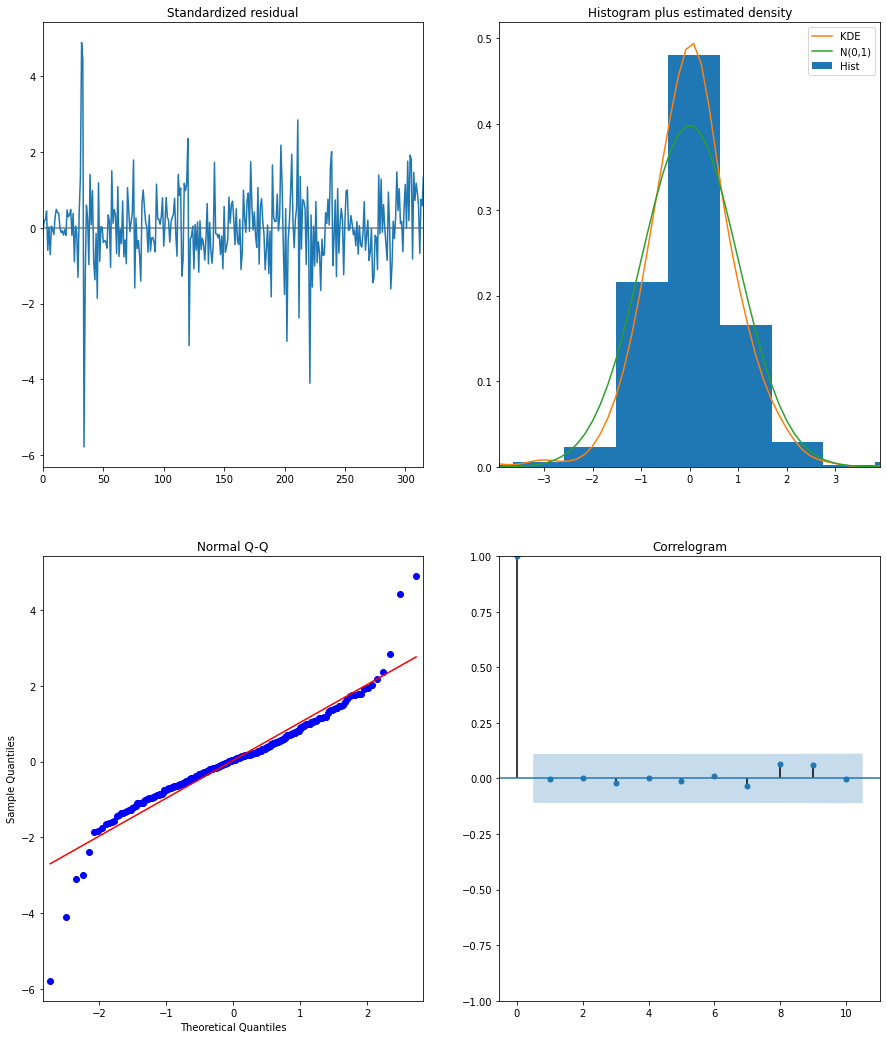

In [64]:
history_type = adj_close #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

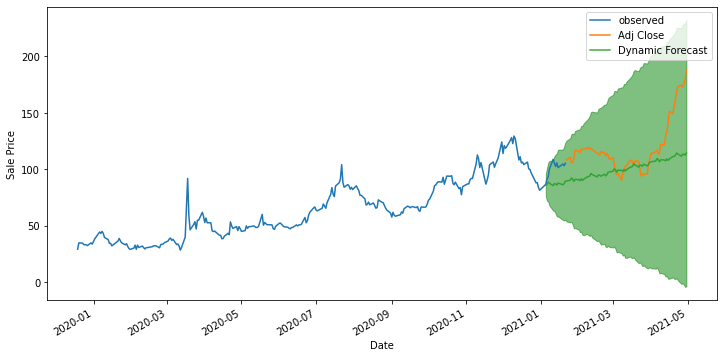

In [65]:
#gren line is forcast
#green shades gives more range for forecast
#one_adj_c = 'Adj Close'
# prediction_visual_3 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_3
prediction_visual_4 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= adj_close)


In [66]:
metric_func_dynamic(pred_dynamic, test, adj_close)

The Mean Squared Error of the forecast is 730.25
The Root Mean Squared Error of the forecast is 27.02


(730.2506207192824, 27.02314971870012)

#### BNTX / MA_50

In [67]:
bntx_stock['MA_50'].describe()

count    343.000000
mean      68.633284
std       28.822540
min       20.794800
25%       43.455500
50%       70.056000
75%      101.338299
max      121.613600
Name: MA_50, dtype: float64

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                 1040
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                2704.633
Date:                                 Fri, 30 Apr 2021   AIC                          -5387.265
Time:                                         16:11:01   BIC                          -5333.280
Sample:                                              0   HQIC                         -5366.747
                                                - 1040                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.5302      0.093     27.254      0.000       2.348       2.712
ar.L2         -2.1067      0.181    -11.633      0.000      -2.462      -1.752
ar.L3          0.5747      0.089      6.477      0.000       0.401       0.749
ma.L1         -0.5134      0.091     -5.654      0.000      -0.691      -0.335
ma.L2          0.2559      0.026      9.743      0.000       0.204       0.307
ma.L3          0.0687      0.040      1.721      0.085      -0.010       0.147
ar.S.L12      -0.3815      0.026    -14.795      0.000      -0.432      -0.331
ar.S.L24      -0.0126      0.026     -0.491      0.624      -0.063       0.038
ma.S.L12       9.3141      0.000   3.02e+04      0.000       9.313       9.315
ma.S.L24      -1.6283      0.004   -464.173      0.000      -1.635      -1.621
sigma2        2.8e-06    1.1e-07     25.467      0.000    2.58e-06    3.02e-06
===================================================================================
Ljung-Box (Q):                      365.54   Jarque-Bera (JB):                69.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+21. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


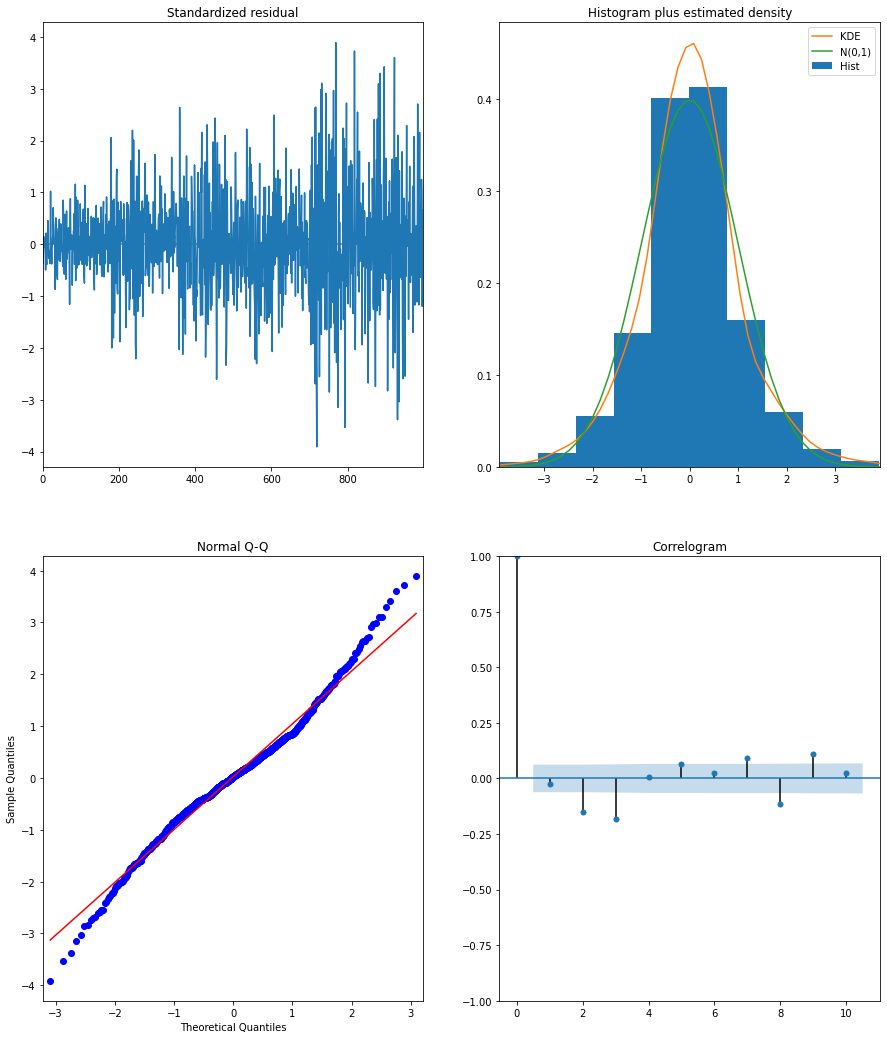

In [68]:
#check
hist_type = ma_50  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=False)
pred_conf = pred.conf_int()

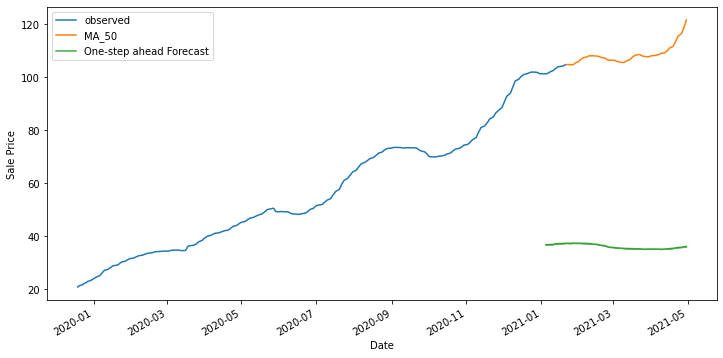

In [69]:
one_step_forecast_5 = one_step(train=train, test=test, one_adj_c= 'MA_50', pred=pred,pred_conf=pred_conf)#'MA_50'


In [70]:
metric_func_one(pred, test, ma_50)

The Mean Squared Error of our forecasts is 5287.07
The Root Mean Squared Error of our forecasts is 72.71


(5287.071391736978, 72.71225063039225)

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                  343
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                 136.810
Date:                                 Fri, 30 Apr 2021   AIC                           -251.620
Time:                                         16:11:09   BIC                           -210.769
Sample:                                              0   HQIC                          -235.276
                                                 - 343                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0033      0.689      2.909      0.004       0.654       3.353
ar.L2         -1.0420      1.345     -0.775      0.438      -3.677       1.593
ar.L3          0.0375      0.657      0.057      0.955      -1.251       1.326
ma.L1          0.1138      0.685      0.166      0.868      -1.229       1.457
ma.L2         -0.0642      0.124     -0.518      0.604      -0.307       0.179
ma.L3         -0.0976      0.085     -1.154      0.249      -0.263       0.068
ar.S.L12      -0.6553      0.281     -2.328      0.020      -1.207      -0.104
ar.S.L24      -0.3229      0.085     -3.780      0.000      -0.490      -0.155
ma.S.L12       6.9948     27.003      0.259      0.796     -45.930      59.920
ma.S.L24      -2.1736      6.090     -0.357      0.721     -14.111       9.763
sigma2         0.0004      0.003      0.136      0.891      -0.006       0.007
===================================================================================
Ljung-Box (Q):                       61.04   Jarque-Bera (JB):                86.27
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.01
Prob(H) (two-sided):                  0.90   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


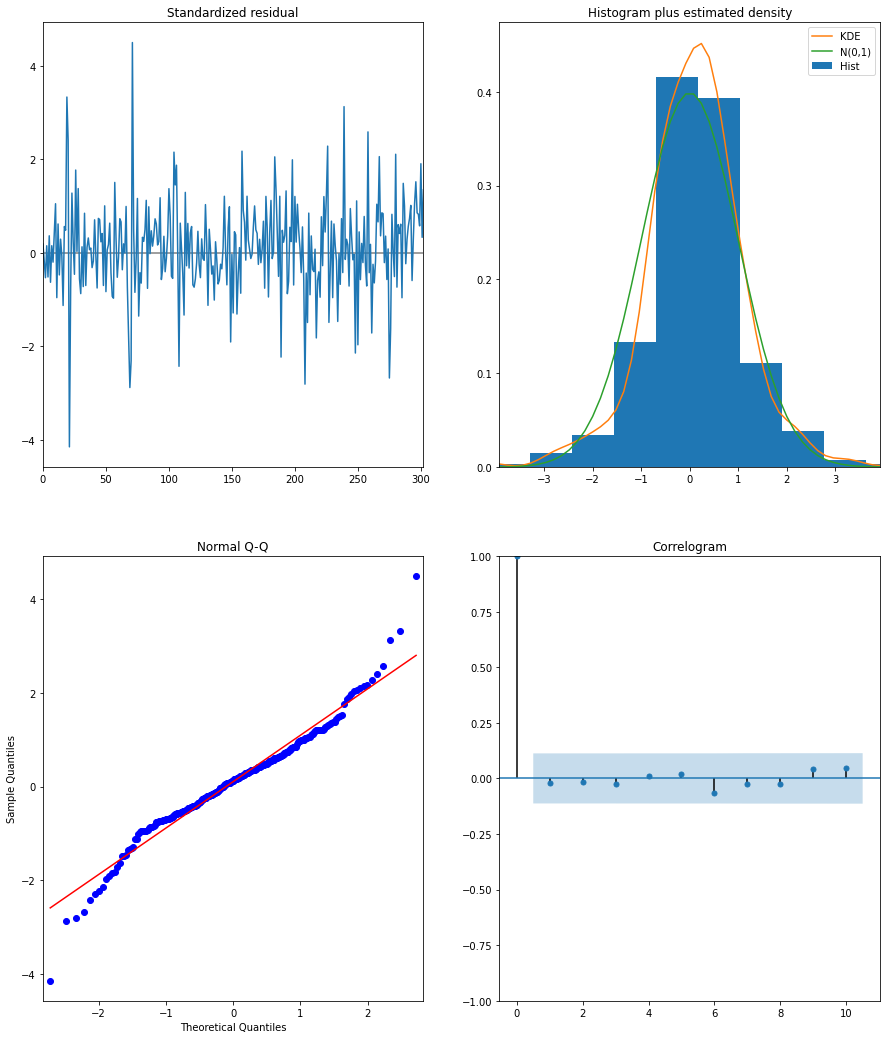

In [71]:
history_type = ma_50 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

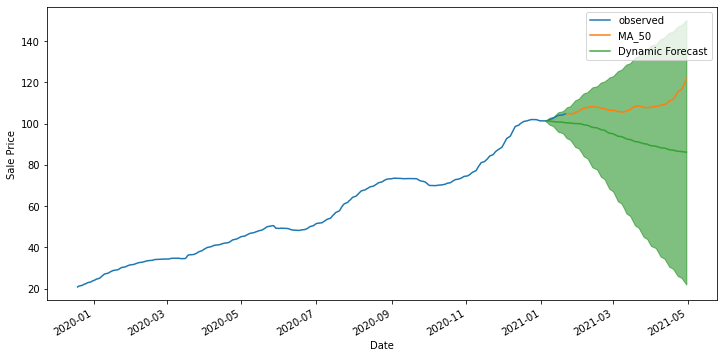

In [72]:
prediction_visual_5 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= ma_50)


In [73]:
metric_func_dynamic(pred_dynamic, test, ma_50)

The Mean Squared Error of the forecast is 300.83
The Root Mean Squared Error of the forecast is 17.34


(300.82793298060324, 17.344391974946923)

#### BNTX / actual_changes

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                 1040
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -720.363
Date:                              Fri, 30 Apr 2021   AIC                           1454.726
Time:                                      16:11:20   BIC                           1489.163
Sample:                                           0   HQIC                          1467.807
                                             - 1040                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8698      0.049    -17.704      0.000      -0.966      -0.773
ma.L1          0.8152      0.052     15.810      0.000       0.714       0.916
ma.L2         -0.0125      0.028     -0.445      0.656      -0.067       0.042
ma.L3          0.0896      0.023      3.967      0.000       0.045       0.134
ar.S.L12     3.23e-06      0.028      0.000      1.000      -0.055       0.055
ma.S.L12      -1.0000      8.890     -0.112      0.910     -18.423      16.423
sigma2         0.2322      2.063      0.113      0.910      -3.811       4.276
===================================================================================
Ljung-Box (Q):                       73.20   Jarque-Bera (JB):              1073.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


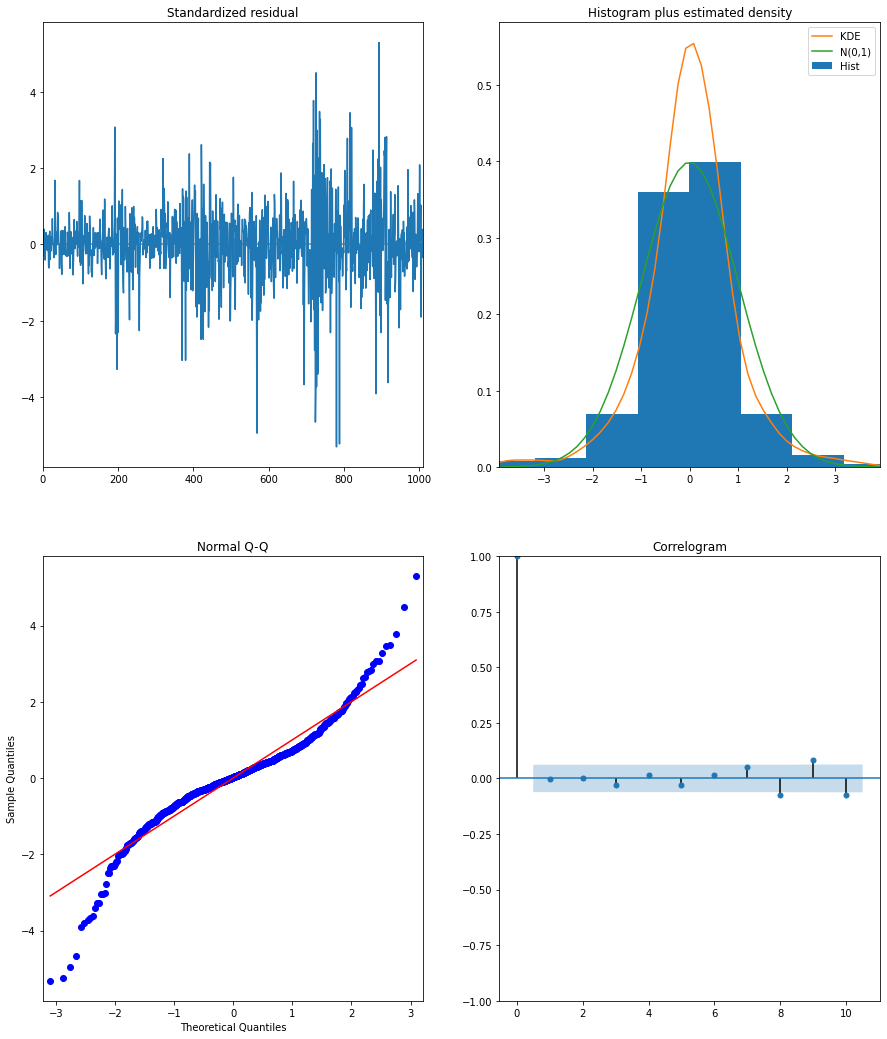

In [74]:
hist_type = actual_changes  
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=False)
pred_conf = pred.conf_int()

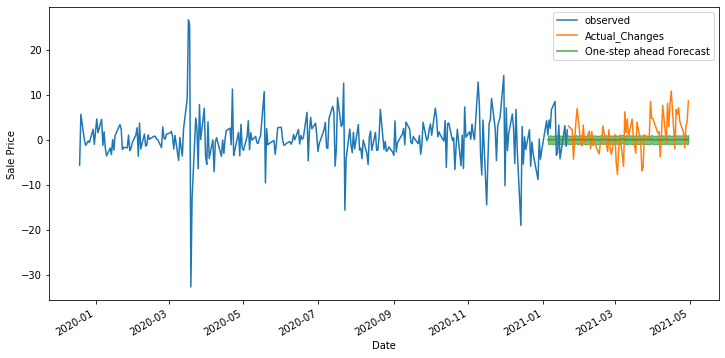

In [75]:
one_step_forecast_5 = one_step(train=train, test=test, one_adj_c= actual_changes, pred=pred,pred_conf=pred_conf)#'MA_50'


In [76]:
metric_func_one(pred, test, actual_changes)

The Mean Squared Error of our forecasts is 17.5
The Root Mean Squared Error of our forecasts is 4.18


(17.49922897532286, 4.1832079765800385)

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                  343
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -968.118
Date:                              Fri, 30 Apr 2021   AIC                           1950.236
Time:                                      16:11:24   BIC                           1976.504
Sample:                                           0   HQIC                          1960.731
                                              - 343                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5221      1.326     -0.394      0.694      -3.121       2.077
ma.L1          0.5769      1.325      0.435      0.663      -2.020       3.174
ma.L2         -0.0579      0.079     -0.732      0.464      -0.213       0.097
ma.L3         -0.0725      0.104     -0.694      0.488      -0.277       0.132
ar.S.L12      -0.0002      0.055     -0.004      0.997      -0.108       0.107
ma.S.L12      -1.0000     63.761     -0.016      0.987    -125.969     123.969
sigma2        24.7250   1576.761      0.016      0.987   -3065.670    3115.120
===================================================================================
Ljung-Box (Q):                       25.40   Jarque-Bera (JB):               555.08
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.25
Prob(H) (two-sided):                  0.41   Kurtosis:                         9.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


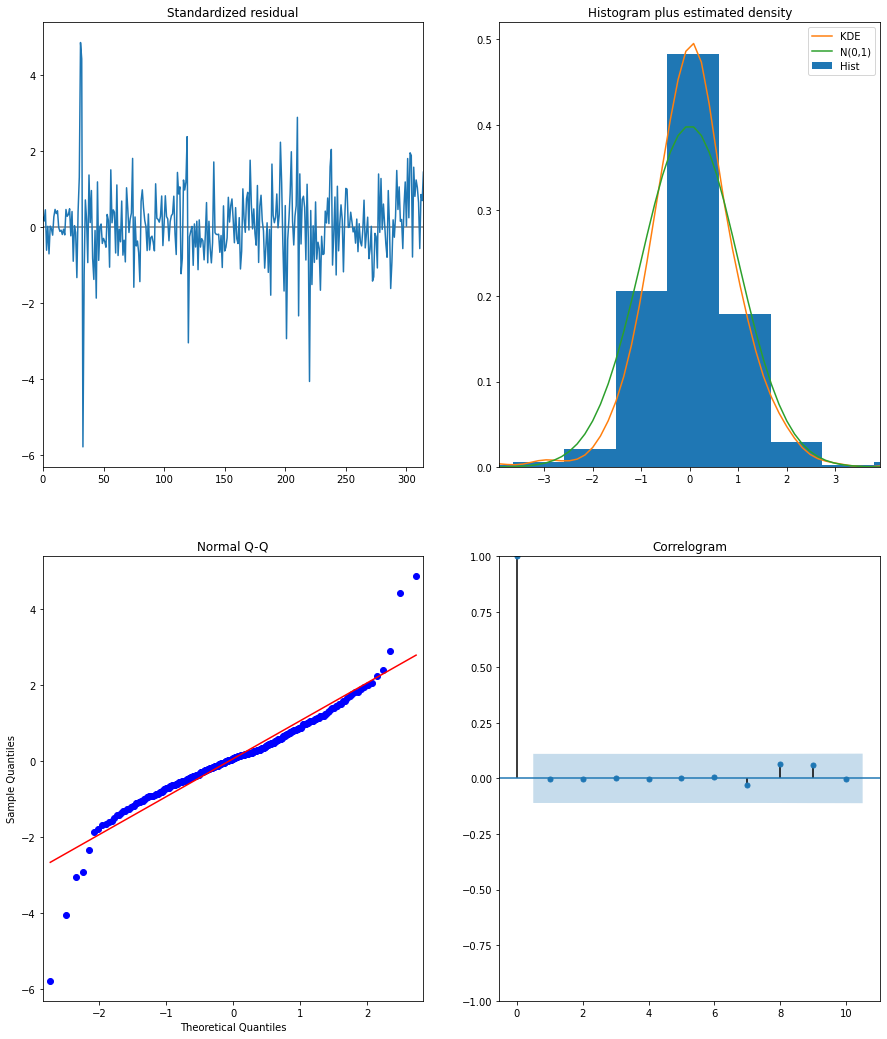

In [77]:
history_type = actual_changes #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

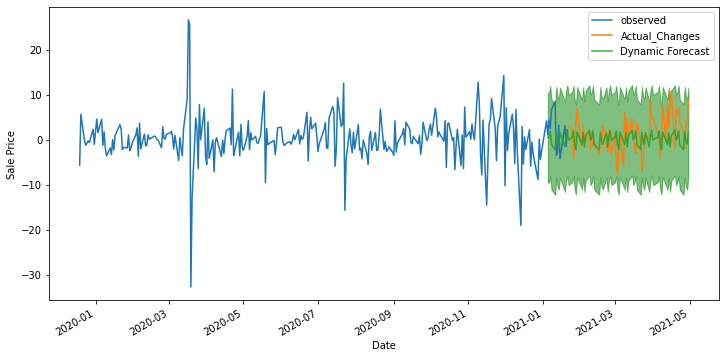

In [78]:
prediction_visual_5 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= actual_changes)


In [79]:
metric_func_dynamic(pred_dynamic, test, actual_changes)

The Mean Squared Error of the forecast is 18.39
The Root Mean Squared Error of the forecast is 4.29


(18.390143641804716, 4.28837307633148)